In [217]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [218]:
N = 6
# Testing vector
X = np.reshape(np.flip(np.arange(3 * N)), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

bars[0,1] = 0.5
bars[1, 2] = 0.5
cables[2,3] = 0.5
bars[3, 4] = 0.5
bars[4,5] = 1
#bars[0,5] = 0.5
"""bars[0, 6] = 0.5
bars[6, 7] = 5
bars[3, 8] = 1
cables[8, 9] = 1"""

'bars[0, 6] = 0.5\nbars[6, 7] = 5\nbars[3, 8] = 1\ncables[8, 9] = 1'

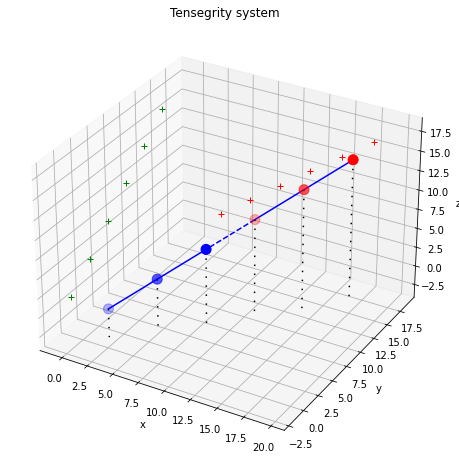

[[-1.75, 20.75], [-2.75, 19.75], [-3.75, 18.75]]

In [241]:
def plot_points(X, bars, cables, M, lims = [None, None, None], title = "Tensegrity system"):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection = '3d')
    ax.set_title(title)
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    
    xlims, ylims, zlims = lims
    if xlims == None:
        xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
        xlims = [xmin - (xmax-xmin) / 4, xmax + (xmax-xmin) / 4]
    if ylims == None:
        ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
        ylims = [ymin - (ymax-ymin) / 4, ymax + (ymax-ymin) / 4]
    if zlims == None:
        zmin, zmax = np.min(X[:,2]), np.max(X[:,2])
        zlims = [zmin - (zmax-zmin) / 4, zmax + (zmax-zmin) / 4]

    ax.scatter(x[:M], y[:M], z[:M], s = 100, c = 'red')
    ax.scatter(x[M:], y[M:], z[M:], s = 100, c = 'blue')

    ax.plot(x, z, 'r+', zdir='y', zs = ylims[1])
    ax.plot(y, z, 'g+', zdir='x', zs= xlims[0])
    #ax.plot(x, y, 'k+', zdir='z', zs= zmin - (zmax-zmin) / 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim3d(xlims[0], xlims[1])
    ax.set_ylim3d(ylims[0], ylims[1])
    ax.set_zlim3d(zlims[0], zlims[1])

    cable_indices = np.asarray(np.where(cables != 0))
    for i, j in cable_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b--')

    bar_indices = np.asarray(np.where(bars != 0))
    for i, j in bar_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b-')

    # Projection down on z
    for i in range(len(z)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], zlims[0]], linestyle = (0, (1, 5)), color = 'black')
    plt.show() 
    return [xlims, ylims, zlims]

plot_points(X, bars, cables, 3)

## Energy functions

In [220]:
g = 9.81
def E_ext(X, ms):
    return g * np.sum(ms * X[:, 2])

rho = 1
c = 1
def E_bar(X, bars):
    bars_indices = np.asarray(np.where(bars != 0))
    grav = 0
    elast = 0
    for i, j in bars_indices.T:
        grav += bars[i, j] * (X[i, 2] + X[j, 2])
        elast += (np.linalg.norm(X[i] - X[j]) - bars[i, j])**2 / bars[i, j]**2
    return rho * g * grav / 2 + c / 2 *  elast

k = 1
def E_cable(X, cables):
    cables_indices = np.asarray(np.where(cables != 0))
    energy = 0
    for i, j in cables_indices.T:
        if np.linalg.norm(X[i] - X[j]) > cables[i, j]:
            energy += (np.linalg.norm(X[i] - X[j]) - cables[i, j])**2 / cables[i, j]**2
    return energy * k / 2 

def E(X, cables, bars, ms):
    Y = X.reshape(len(ms), 3)
    return E_ext(Y, ms) + E_bar(Y, bars) + E_cable(Y, cables)

# Test
ms = 0.1 * np.ones(N)
print(E(X, cables, bars, ms))

383.88712819564034


In [221]:
a = np.arange(9).reshape((3,3))
print(a)
print(np.vstack((-a,a)))
print(a.flatten())
print(a.flatten()[2::3])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[ 0 -1 -2]
 [-3 -4 -5]
 [-6 -7 -8]
 [ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]]
[0 1 2 3 4 5 6 7 8]
[2 5 8]


### Derivative of energy functions

In [222]:
def dE_ext(X, ms, P, N, M):
    deriv = np.zeros(3 * (N - M))
    deriv[2::3] = ms[M:]
    return g * deriv.flatten()
#np.concatenate((np.zeros((N, 2)), ms)).flatten()

def dE_bar(Y, bars, P, N, M):
    bars_indices = np.asarray(np.where(bars != 0))
    grav = np.zeros((N, 3))
    elast = np.zeros((N, 3))
    X = np.vstack((P, Y))
    for i, j in bars_indices.T:
        norm = np.linalg.norm(X[i] - X[j])
        grav[i] += np.array([0, 0, bars[i, j]])
        grav[j] += np.array([0, 0, bars[i, j]])
        elast[i] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([X[i, 0] - X[j, 0], X[i, 1] - X[j, 1], X[i, 2] - X[j, 2]])
        elast[j] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([-X[i, 0] + X[j, 0], -X[i, 1] + X[j, 1], -X[i, 2] + X[j, 2]])

    return rho * g * grav[M:].flatten() / 2 + c *  elast[M:].flatten()

def dE_cable(Y, cables, P, N, M):
    cable_indices = np.asarray(np.where(cables != 0))
    elast = np.zeros((N, 3))
    X = np.vstack((P, Y))
    for i, j in cable_indices.T:
        norm = np.linalg.norm(X[i] - X[j])
        if norm > cables[i, j]:
            elast[i] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([X[i, 0] - X[j, 0], X[i, 1] - X[j, 1], X[i, 2] - X[j, 2]])
            elast[j] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([-X[i, 0] + X[j, 0], -X[i, 1] + X[j, 1], -X[i, 2] + X[j, 2]])
    return k * elast[M:].flatten()

def dE(X, P, cables, bars, ms, N, M):
    Y = X.reshape(N - M, 3)
    gradient = (dE_ext(Y, ms, P, N, M) + dE_bar(Y, bars, P, N, M) + dE_cable(Y, cables, P, N, M))
    """print("Ext ",dE_ext(Y, ms, P, N, M))
    print("Bar ", dE_bar(Y, bars, P, N, M))
    print("Cable", dE_cable(Y, cables, P, N, M))"""
    return gradient
M = 1
print(dE(X[M:], X[:M], cables, bars, ms, N, M))

[ 0.          0.          5.886       0.          0.          3.4335
  0.          0.          3.4335     -8.42264973 -8.42264973 -0.08414973
 -2.42264973 -2.42264973  3.46335027]


In [223]:
def armijo(x, alpha, p, c1, f, df):
    return f(x + alpha * p) <= f(x) + c1 * alpha * np.inner(df(x), p)

def curvature(x, alpha, p, c2, df):
    return -np.inner(df(x + alpha * p), p) <= -c2 * np.inner(df(x), p)

def backtracking(x, p, c1, c2, f, df, maxiter = 100):
    assert(c1 < c2)
    alpha_min, alpha_max = 0, np.inf
    alpha = 5
    I = armijo(x, alpha, p, c1, f, df)
    II = curvature(x, alpha, p, c2, df)
    iter = 0
    while not (I and II):
        if iter > maxiter:
            break
        if not I:
            alpha_max = alpha
            alpha = (alpha_min + alpha_max) / 2
        else:
            alpha_min = alpha
            if alpha_max < np.inf:
                alpha = (alpha_min + alpha_max) / 2
            else:
                alpha *= 2
        I = armijo(x, alpha, p, c1, f, df)
        II = curvature(x, alpha, p, c2, df)
        #print(alpha, I, II)
        iter += 1
    return alpha

def backtracking2(x, p, c1, ro, f, df):
    alpha = 10
    while not armijo(x, alpha, p, c1, f, df):
        alpha *= ro
    return alpha

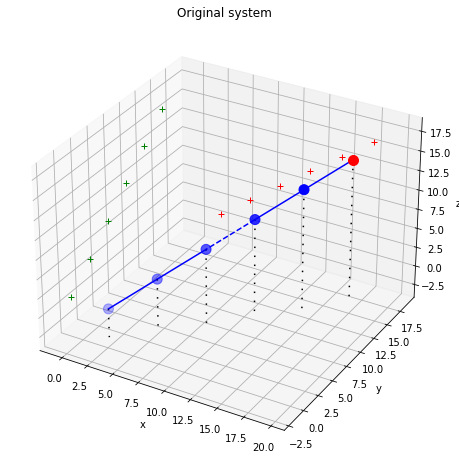

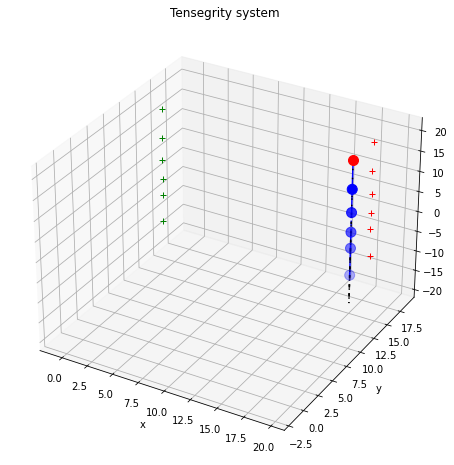

[-2.98081322e-04 -2.98081322e-04 -2.83148289e-03  3.69619924e-04
  3.69619924e-04  3.43186501e-03  6.87357703e-04  6.87357703e-04
 -2.47830315e-03  8.82507871e-05  8.82507871e-05  6.16847084e-04
  6.06512193e-04  6.06512193e-04 -2.58632783e-04] [ 2.07588593e-05  2.07588593e-05 -1.06552809e-05 -2.68198025e-04
 -2.68198025e-04  3.72360064e-04 -4.34046116e-04 -4.34046116e-04
 -3.35854793e-04 -2.86994279e-04 -2.86994279e-04  4.18780530e-04
 -5.71904133e-04 -5.71904133e-04  1.90237096e-04]
142.23003864095205
38.97441504992715


In [246]:
def BFGS(X0, N, M, cables, bars, ms, maxiter):
    original_limits = plot_points(X0.reshape((N,3)), bars, cables, M, title = 'Original system')
    P = X0[:3 * M]
    Y0 = X0[3 * M:]
    def f(y):
        X = np.concatenate((P, y))
        return E(X, cables, bars, ms)

    def df(y):
        return dE(y, P.reshape(M, 3), cables, bars, ms, N, M)

    c1, c2 = 0.025, 0.2
    # First: Gradient descent
    p = -df(Y0)
    #alpha = backtracking(Y0, p, c1, c2, f, df)
    alpha = backtracking(Y0, p, c1, c2, f, df)
    Y1 = Y0 + alpha * p

    sk = Y1 - Y0
    yk = df(Y1) - df(Y0)
    H = np.inner(yk, sk) / np.inner(yk, yk) * np.eye(3 * (N - M))

    for k in range(maxiter):
        #p = -H @ df(Y1)
        p = -df(Y1)
        
        #print("Inner", np.inner(df(Y1), p))
        #alpha = backtracking(Y1, p, c1, c2, f, df)
        alpha = backtracking(Y1, p, c1, c2, f, df)
        #print(alpha, f(Y1))
        Y0 = Y1
        Y1 = Y0 + alpha * p
        
        sk = Y1 - Y0
        yk = df(Y1) - df(Y0)
        Hkyk = H@yk
        Sk = 1 / np.inner(sk, yk)
        H = H - Sk * (sk @ Hkyk.T + Hkyk @ sk.T) + sk @ sk.T * (Sk**2 * np.inner(yk, Hkyk) + Sk)
    original_limits[2] = None
    plot_points((np.concatenate((P, Y1))).reshape(N, 3), bars, cables, M, lims = original_limits)
    print(p, df(Y1))
    print(E_bar(np.concatenate((P, Y1)).reshape((N,3)), bars))
    print(E_cable(np.concatenate((P, Y1)).reshape((N,3)), cables))

M = 1
BFGS(X.flatten(), N, M, cables, bars, ms, 100)